# Assignment 6
**CS283 Computer Vision, Harvard University, Fall 2023**

**Due Wednesday, Oct. 18, at 11:59pm**

Name One: *Alexia Hartogensis* \
Name Two: *Bach Nguyen*

---

This assignment reinforces your understanding of multi-resolution image representations and filtering in space and time. As usual, the assignment will be submitted electronically and formatted according to the guidelines.

Like Asignment 4, this assignment is **meant to be completed in pairs**. You and your teamate will collaborate in the design and implementation of your solution in a single colab notebook. At submission time, each teamate will submit a copy of the notebook to Gradescope, along with their own supplemental PDF that includes a one-paragraph description of their own contributions and their teamate's contributions.

If you have not already done so, identify a teamate, and then begin by creating a copy of this notebook in your google drive at filepath `My Drive/cs-283-assignments/A6/pset6.ipynb`. Then edit the notebook and submit it according to the instructions on the course website.

Acknowledgement: Some questions on this assignment were adapted from MIT course 6.869, Advances in Computer Vision by Bill Freeman and Philip Isola.

***

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# YOU SHOULD HAVE ALREADY COPIED OVER THE ASSIGNMENT FILES TO A FOLDER
# TITLED "cs-283-assignments" ON YOUR GOOGLE DRIVE

%cd "/content/drive/My Drive/cs-283-assignments/A6"

# %cd "/content/drive/MyDrive/Courses/CS_283/CS283_2023/Assignments/repo/CS283-2023/assignments/pset6"


/content/drive/My Drive/cs-283-assignments/A6


In [3]:
# Download source files
!curl https://codeload.github.com/Harvard-CS283/pset-data/tar.gz/main | \
  tar -xz --strip=2 pset-data-main/pset6/data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60.7M    0 60.7M    0     0  24.4M      0 --:--:--  0:00:02 --:--:-- 24.5M


In [4]:
# install pyrtools (https://pyrtools.readthedocs.io/en/latest/)
!pip install pyrtools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyrtools: filename=pyrtools-1.0.1-cp310-cp310-linux_x86_64.whl size=101856 sha256=9c46d8eca3f45d131dde8bc999da8c382c5c6e0e4c3513aa7b3e4e0e8be74663
  Stored in directory: /root/.cache/pip/wheels/8b/60/af/95a791cd90adbd48bd14d32f181989cf3e5444b49ca20e94dd
Successfully built pyrtools


In [5]:
# Imports other required libraries here
import cv2            # OpenCV
import numpy as np    # numpy
import pyrtools as pt # pyrtools

# various file and image handling (especially for animated GIF files)
import requests
from PIL import Image, ImageFilter
import imageio
from IPython.display import Image as IPyImage, display

# direct import some particular numpy modules to simplify the code
from numpy.fft import fftshift, fft, ifft, fft2, ifft2
from numpy import angle, real
from numpy import exp, abs, pi, sqrt

import matplotlib.pyplot as plt
# Modify this line to adjust the displayed plot size. You can also call
# it with different parameters before specific plots, or use
# plt.figure(figsize=[10, 10]) instead.
plt.rcParams['figure.figsize'] = [10, 10]

## Question 2 (30%)

In this question you use the phase information in a DFT to amplify the translational motion between two images.

1. Examine the code and output of the cell titled **1D Demonstration**, immediately below this text cell.

2. Implement two-dimensional extensions of the 1D demonstration by completing parts **a**, **b**, **c** below.

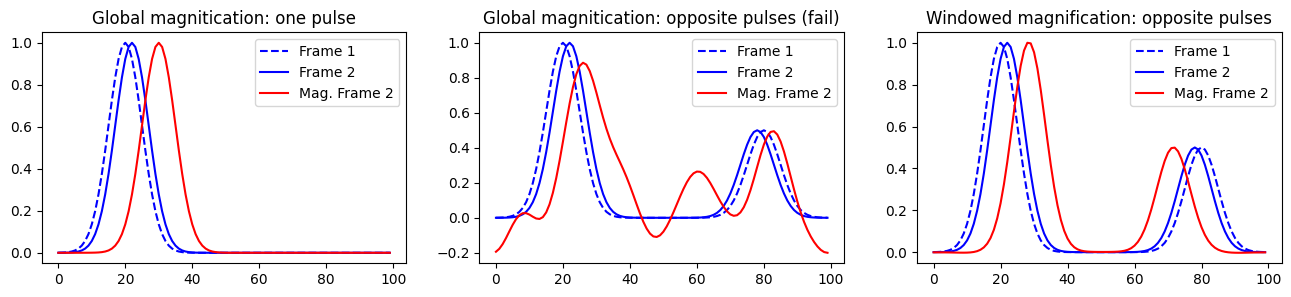

In [9]:
#@title 1D Demonstration
x = np.arange(100)    # signal domain
MAGFACTOR = 5         # magnification factor

## Experiment 1:
## Magnify the motion that exists between two frames of a 1D moving pulse,
## using the phase information provided by a global Fourier transform.
## It works.

# input frames: one moving pulse
f1 = exp(-(x - 20)**2/(2*5**2))   # frame 1
f2 = exp(-(x - 22)**2/(2*5**2))   # frame 2

# DFT to go to frequency domain
F1 = fft(f1)
F2 = fft(f2)

# measure phase shifts from F1 to F2 (elementwise, meaning at each spatial frequency)
phaseShift = np.angle(F2) - np.angle(F1)

# replace the original phases of F2 with magnified versions
F2mag = np.abs(F2)*exp(1j*(np.angle(F1) + MAGFACTOR*phaseShift))

# inverse DFT to go back to spatial domain
f2mag = np.abs(ifft(F2mag))

# plot results
plt.figure(figsize=(16, 3))
plt.subplot(131)
plt.plot(x,f1,'b--')
plt.plot(x,f2,'b')
plt.plot(x,f2mag,'r')
plt.title('Global magnitication: one pulse')
plt.legend(['Frame 1','Frame 2','Mag. Frame 2'])

## Experiment 2:
## Attempt magnification of two pulses moving in opposite directions.
## It fails because the phase information about each of the two pulses
## gets "mixed together" by the global Fourier basis.

# input frames: two moving pulses
f1 = exp(-(x - 20)**2/(2*5**2)) + 1/2 * exp(-(x - 80)**2/(2*5**2))
f2 = exp(-(x - 22)**2/(2*5**2)) + 1/2 * exp(-(x - 78)**2/(2*5**2))

# magnify motion: same as above, but with condensed code
F1 = fft(f1)
F2 = fft(f2)
phaseShift = np.angle(F2) - np.angle(F1)
f2mag = real(ifft(np.abs(F2)*exp(1j*(np.angle(F1) + MAGFACTOR*phaseShift))))

# plot results
plt.subplot(132)
plt.plot(x,f1,'b--')
plt.plot(x,f2,'b')
plt.plot(x,f2mag,'r')
plt.title('Global magnitication: opposite pulses (fail)')
plt.legend(['Frame 1','Frame 2','Mag. Frame 2'])

## Experiment 3:
## Magnify motion of the same two pulses using windowed Fourier transform.
## Do this by:
##   a) multiplying frames 1 and 2 by shifting Gaussian windows having fixed width
##      SIGMA and center locations $\mu$ that sweep over all pixels in a frame
##   b) for each Gaussian window position, use the algorithm above to
##      magnify the motion in that windowed portion of frame 2
##   c) sum all of the window-magnified frame 2's together
##
## The summation in Step (c) causes the output to have a very large maximum
## value. So undo this at the end by multiplying it by a scalar value that
## is less (e.g., by the ratio between the maximum value of input frame 2 and
## the maximum value of the Step (c) output).

# input: two moving pulses (same as Experiment 2)
f1 = exp(-(x - 20)**2/(2*5**2)) + 1/2 * exp(-(x - 80)**2/(2*5**2))
f2 = exp(-(x - 22)**2/(2*5**2)) + 1/2 * exp(-(x - 78)**2/(2*5**2))

# standard deviation of Gaussian window
SIGMA = 10

# initialize output image to all-zeros
f2mag = np.zeros(f2.shape)

# loop Gaussian window over spatial locations, magnify motion
#   in each window, and add it to f2mag
for mu in x:
  gaussianMask=(2*np.sqrt(SIGMA)) * exp(-(x - mu)**2/(2*SIGMA**2))
  F1 = fft(f1 * gaussianMask)
  F2 = fft(f2 * gaussianMask)
  phaseShift = np.angle(F2) - np.angle(F1)
  f2mag = f2mag + real(ifft(np.abs(F2)*exp(1j*(np.angle(F1) + MAGFACTOR*phaseShift))))

# Note that f2mag has a very large maximum value because of the summation
# over multiple Gaussian windows covering each location x. We could have
# fixed this by including appropriate weights during the addition in line
# [f2mag = f2mag + ##], but instead we simply re-scale f2mag to have the
# same maximum value as f2.
f2mag = f2mag*max(f2)/max(f2mag)

# plot results
plt.subplot(133)
plt.plot(x,f1,'b--')
plt.plot(x,f2,'b')
plt.plot(x,f2mag,'r')
plt.title('Windowed magnification: opposite pulses')
plt.legend(['Frame 1','Frame 2','Mag. Frame 2'])


###**a.**  Two frames of a single moving pulse###

Magnify the motion that exists between two frames of a single moving pulse in a $9\times 9$ image (i.e., a white pixel on a black background) using the phase information provided by a global discrete Fourier transform.

Do this by adapting the 1D code that was used for the first 1D demonstration (the left-most plot) above. For example, you must replace `fft` with `fft2`.

In [10]:
# simple helper function: display grayscale images with clipping at 1
def imshow(im, cmap='gray'):
    # clip image from 0-1
    im = np.clip(im, 0, 1)
    plt.imshow(im, cmap=cmap)

(-0.5, 8.5, 8.5, -0.5)

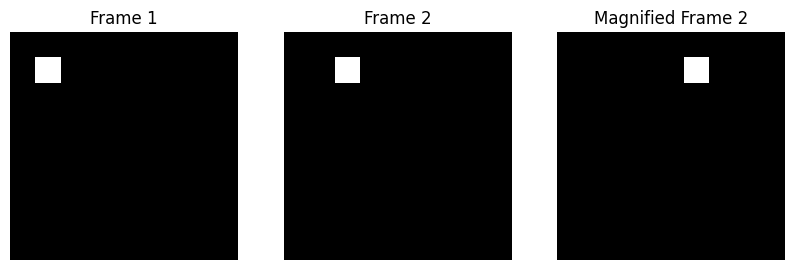

In [11]:
# Generate two input video frames of a single white moving pulse from pixel (1,1) to pixel (1,2)
imSize = 9
im1 = np.zeros([imSize, imSize])
im1[1,1] = 1
im2 = np.zeros([imSize, imSize])
im2[1,2] = 1


# use this magnification factor
MAGFACTOR = 4


#write your magnification code here, replacing the following line of code

# DFT to go to frequency domain
F1 = fft2(im1)
F2 = fft2(im2)

# measure phase shifts from F1 to F2 (elementwise, meaning at each spatial frequency)
phaseShift = np.angle(F2) - np.angle(F1)

im2mag = real(ifft2(np.abs(F2)*exp(1j*(np.angle(F1) + MAGFACTOR*phaseShift))))

# display the results
plt.figure(figsize=(10,3))
plt.subplot(131)
imshow(im1)
plt.title('Frame 1')
plt.axis('off')
plt.subplot(132)
imshow(im2)
plt.title('Frame 2')
plt.axis('off')
plt.subplot(133)
imshow(im2mag)
plt.title('Magnified Frame 2')
plt.axis('off')

###**b.** Two frames of two moving pulses, global transform###

Attempt to magnify the motion that exists between two  frames of two oppositely-moving pulses using the phase information provided by a global discrete Fourier
transform.

This will fail, similar to the middle plot in the 1D example above.

(-0.5, 8.5, 8.5, -0.5)

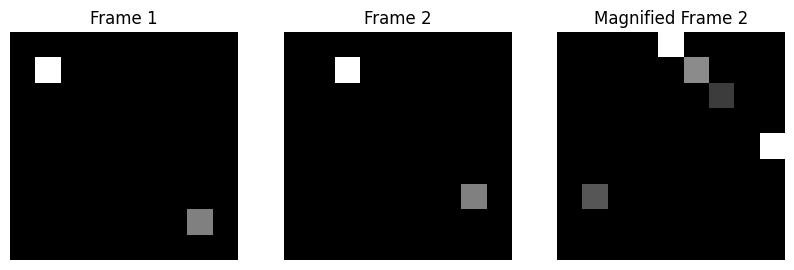

In [12]:
# input video frames of two moving pulses, a white pulse moving
# horizontalluy from pixel (1,1) to pixel (2,1) and a gray pulse moving
# vertically from pixel (7,7) to pixel (7,6)
imSize = 9
im1 = np.zeros([imSize, imSize])
im1[1,1] = 1
im1[7,7] = 0.5
im2 = np.zeros([imSize, imSize])
im2[1,2] = 2
im2[6,7] = 0.5

# use this magnification factor
MAGFACTOR = 4


#write your magnification code here, replacing the following line of code
F1 = fft2(im1)
F2 = fft2(im2)
phaseShift = np.angle(F2) - np.angle(F1)
im2mag = real(ifft2(np.abs(F2)*exp(1j*(np.angle(F1) + MAGFACTOR*phaseShift))))


# display the results
plt.figure(figsize=(10,3))
plt.subplot(131)
imshow(im1)
plt.title('Frame 1')
plt.axis('off')
plt.subplot(132)
imshow(im2)
plt.title('Frame 2')
plt.axis('off')
plt.subplot(133)
imshow(im2mag)
plt.title('Magnified Frame 2')
plt.axis('off')

###**c.** Two frames of two moving pulses, windowed Fourier transform###

Now magnify the motion that exists between the same two video frames, but this time use a windowed Fourier
transform.

Try different widths `SIGMA` for the Gaussian window, selecting one that provides satisfactory results.

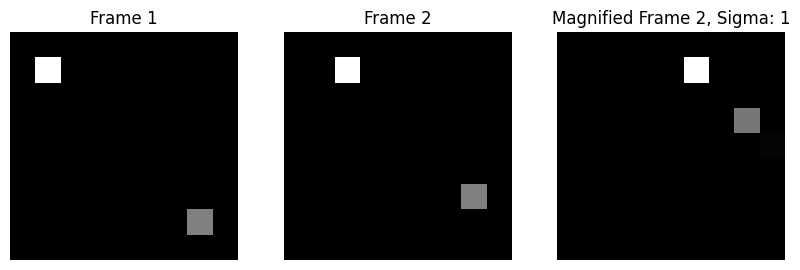

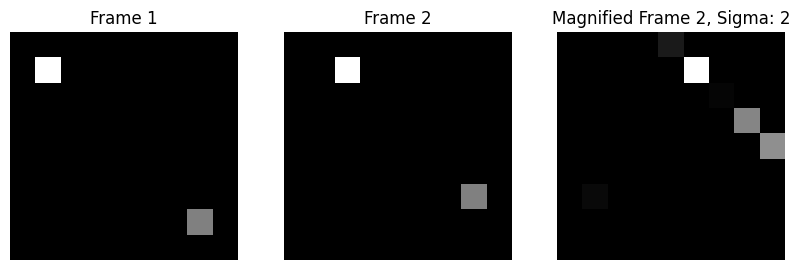

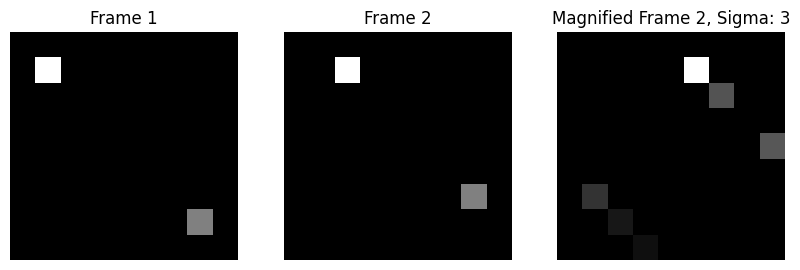

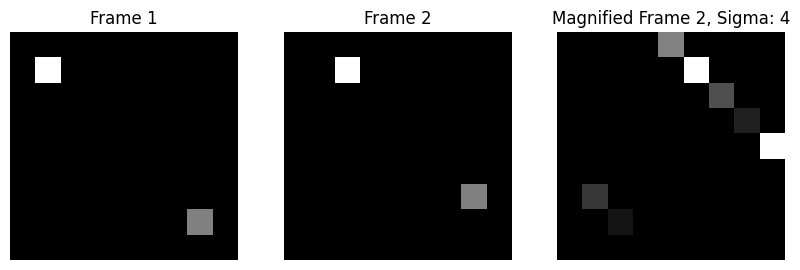

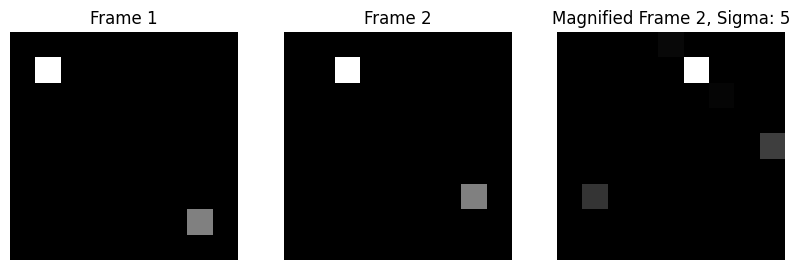

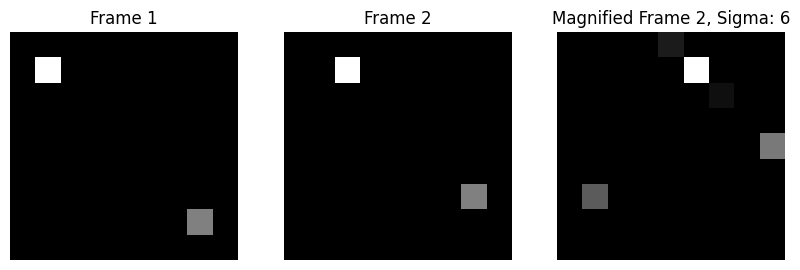

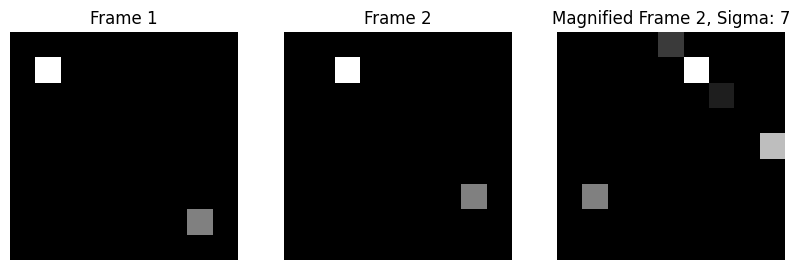

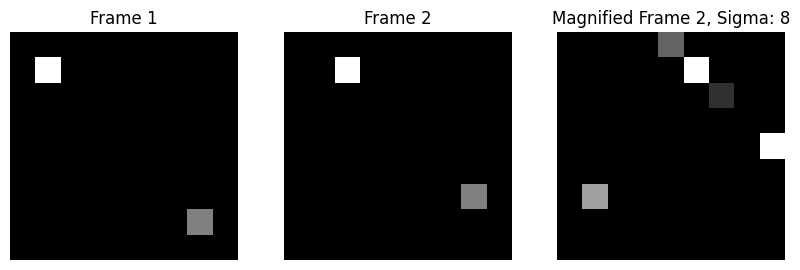

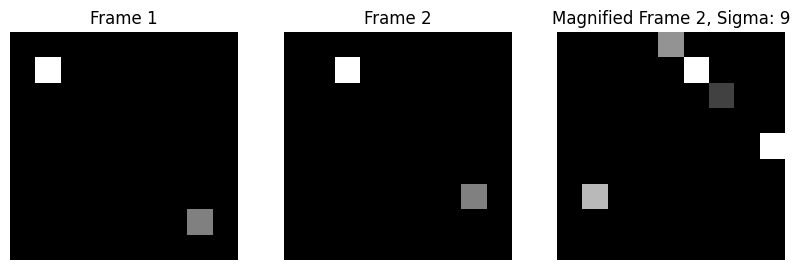

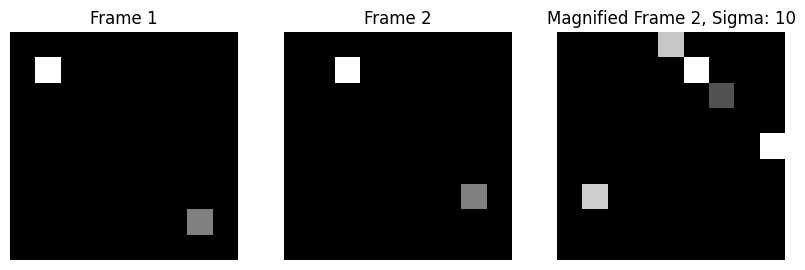

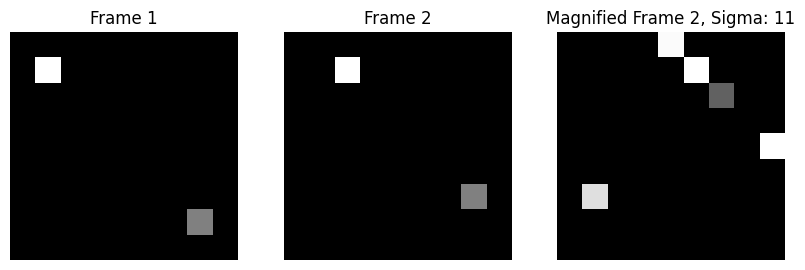

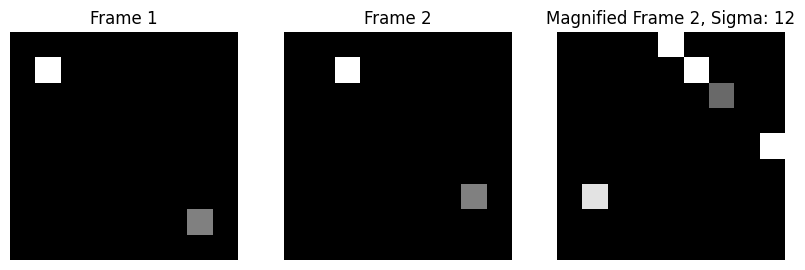

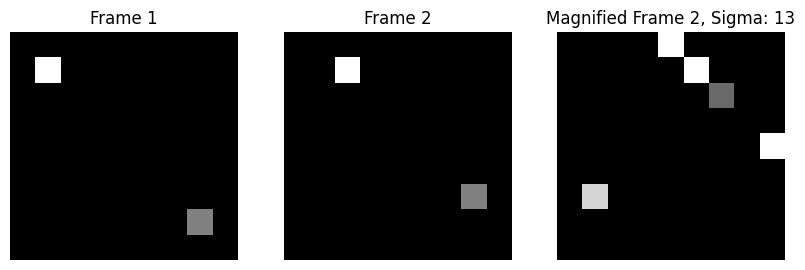

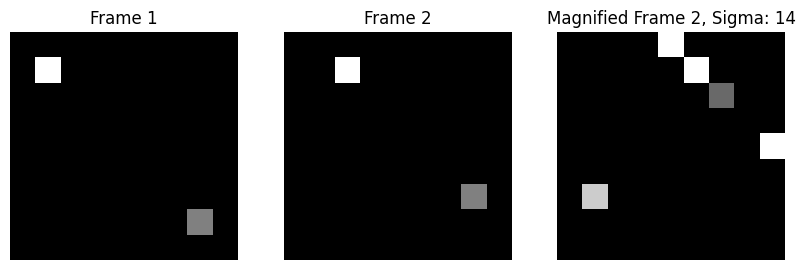

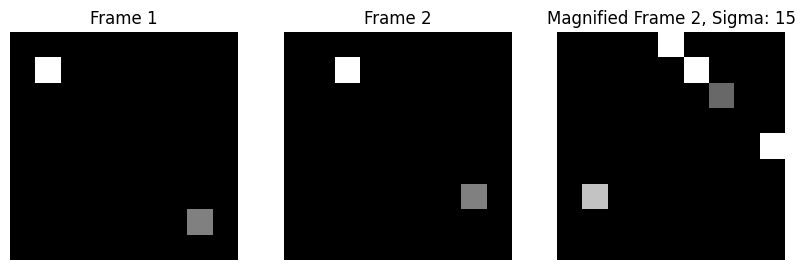

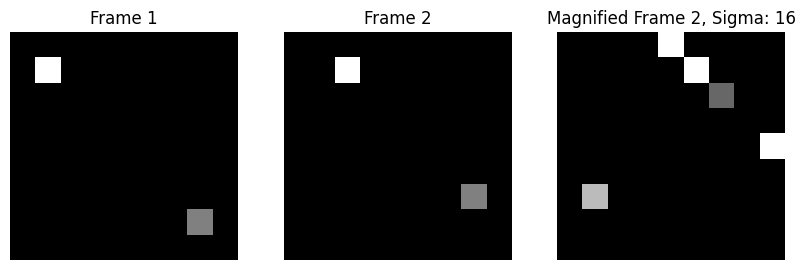

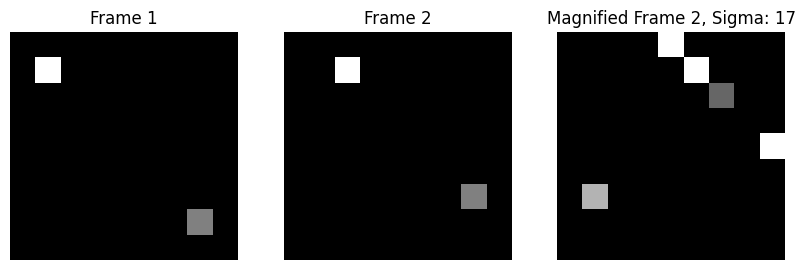

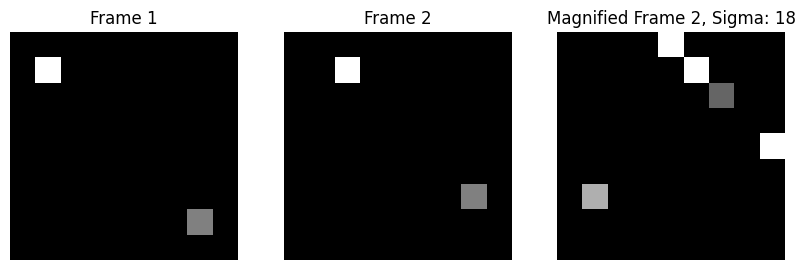

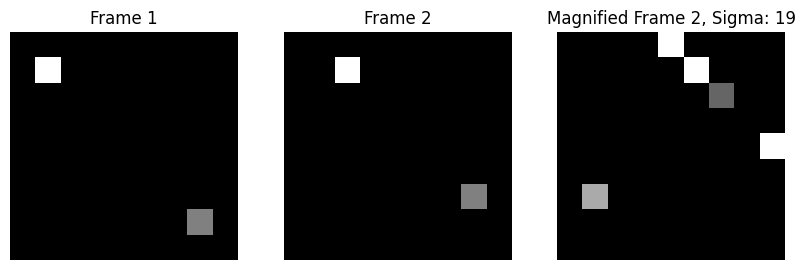

In [32]:
# input video frames of two moving pulses, a white pulse moving
# horizontalluy from pixel (1,1) to pixel (2,1) and a gray pulse moving
# vertically from pixel (7,7) to pixel (7,6)
imSize = 9
im1 = np.zeros([imSize, imSize])
im1[1,1] = 1
im1[7,7] = 0.5
im2 = np.zeros([imSize, imSize])
im2[1,2] = 2
im2[6,7] = 0.5

# use this magnification factor
MAGFACTOR = 4

for i in range(1,20):
  # standard deviation of Gaussian window
  SIGMA = i

  # generate a Gaussian window at each pixel location (mu_x, mu_y), magnify
  # the motion in each window, and sum the per-window results into output
  # im2mag. To speed things up, only place the window at a subset of pixel
  # locations that are evenly spaced in increments of 2*SIGMA
  im2mag = np.zeros_like(im2)
  for mu_y in range(0, imSize, 2*SIGMA):
      for mu_x in range(0, imSize, 2*SIGMA):

          # TO DO: write your magnification code here, replacing the following line
          gaussianMask = (2 * np.sqrt(SIGMA)) * np.exp(-((np.arange(imSize) - mu_x) ** 2 + (np.arange(imSize) - mu_y) ** 2) / (2 * SIGMA**2))

          F1 = fft2(im1 * gaussianMask)
          F2 = fft2(im2 * gaussianMask)
          phaseShift = np.angle(F2) - np.angle(F1)

          im2mag = im2mag + real(ifft2(np.abs(F2)*exp(1j*(np.angle(F1) + MAGFACTOR*phaseShift))))

  # Note that f2mag has a very large maximum value because of the summation
  # over multiple Gaussian windows covering each location x. We could have
  # fixed this by including appropriate weights during the addition in line
  # [f2mag = f2mag + ##], but instead we simply re-scale f2mag to have the
  # same maximum value as f2.
  max_im2 = np.max(im2)
  max_im2mag = np.max(im2mag)
  im2mag = im2mag * max_im2 / max_im2mag


  # display the results
  plt.figure(figsize=(10,3))
  plt.subplot(131)
  imshow(im1)
  plt.title('Frame 1')
  plt.axis('off')
  plt.subplot(132)
  imshow(im2)
  plt.title('Frame 2')
  plt.axis('off')
  plt.subplot(133)
  imshow(im2mag)
  plt.title(f'Magnified Frame 2, Sigma: {SIGMA}')
  plt.axis('off')


In [ ]:
SIGMA = 1

# generate a Gaussian window at each pixel location (mu_x, mu_y), magnify
# the motion in each window, and sum the per-window results into output
# im2mag. To speed things up, only place the window at a subset of pixel
# locations that are evenly spaced in increments of 2*SIGMA
im2mag = np.zeros_like(im2)
for mu_y in range(0, imSize, 2*SIGMA):
    for mu_x in range(0, imSize, 2*SIGMA):

        # TO DO: write your magnification code here, replacing the following line
        gaussianMask = (2 * np.sqrt(SIGMA)) * np.exp(-((np.arange(imSize) - mu_x) ** 2 + (np.arange(imSize) - mu_y) ** 2) / (2 * SIGMA**2))

        F1 = fft2(im1 * gaussianMask)
        F2 = fft2(im2 * gaussianMask)
        phaseShift = np.angle(F2) - np.angle(F1)

          im2mag = im2mag + real(ifft2(np.abs(F2)*exp(1j*(np.angle(F1) + MAGFACTOR*phaseShift))))

  # Note that f2mag has a very large maximum value because of the summation
  # over multiple Gaussian windows covering each location x. We could have
  # fixed this by including appropriate weights during the addition in line
  # [f2mag = f2mag + ##], but instead we simply re-scale f2mag to have the
  # same maximum value as f2.
  max_im2 = np.max(im2)
  max_im2mag = np.max(im2mag)
  im2mag = im2mag * max_im2 / max_im2mag


  # display the results
  plt.figure(figsize=(10,3))
  plt.subplot(131)
  imshow(im1)
  plt.title('Frame 1')
  plt.axis('off')
  plt.subplot(132)
  imshow(im2)
  plt.title('Frame 2')
  plt.axis('off')
  plt.subplot(133)
  imshow(im2mag)
  plt.title(f'Magnified Frame 2, Sigma: {SIGMA}')
  plt.axis('off')

Sigma equaling 1 gives the best results for the magnified pulse.

## Question 3 (30% + 20% bonus)

In this question you build on Question 2 by amplifying motion over a longer video sequence. The assignment's `data` folder contains two videos stored as animated GIFs. One of them, `wobblyH.gif` contains a single moving object, and the other one, `wobblyHU.gif` contains two differently-moving objects.



**a.** Read Section 3.1 of the paper [Phase-Based Video Motion Processing](http://people.csail.mit.edu/nwadhwa/phase-video/phase-video.pdf) by Wadhwa et al.  (2013). (Optionally, use this communal [Perusall version of the paper](https://app.perusall.com/courses/compsci-283-advanced-computer-vision-622953913/phase-based-video-motion-processing) to collaboratively discuss its details with other students and with the teaching staff.)

Then write code that amplifies the single-object motion in `wobblyH.gif` and stores the results in an animated GIF file `magnifiedH.gif`. Since the entire image experiences the same motion, your code can succeed with global Fourier filters on each frame, and so your code should include the following steps:
* compute a global discrete 2D Fourier Transform of each frame
* temporally filter the time-varying phase signal at each spatial frequency (to remove the temporal "DC components")
* multiply the filtered phase values by a magnification factor
* replace the original per-frame phase values with the filtered-and-magnified ones; and
* compute the inverse DFT of each frame

Also, write a one-paragraph description of your approach, including your choice for the temporal filter and how it was implemented.

In [14]:
# Load the GIF file, convert frames to grayscale and scale to [0,1]
input_path = 'data/wobblyH.gif'

frames = [np.array(frame) / 255.0 for frame in imageio.get_reader(input_path)]

# display the animated GIF
display(IPyImage(filename=input_path))

In [15]:
def mag_frame(im1, im2, sigma, mag_factor):
  im2mag = np.zeros_like(im2)
  height = im2.shape[0]
  width = im2.shape[1]
  for mu_y in range(0, height, 2*sigma):
      for mu_x in range(0, width, 2*sigma):
          gaussianMask = (2 * np.sqrt(sigma)) * np.exp(-((np.arange(width) - mu_x) ** 2 + (np.arange(height) - mu_y) ** 2) / (2 * sigma**2))

          F1 = fft2(im1 * gaussianMask)
          F2 = fft2(im2 * gaussianMask)
          phaseShift = np.angle(F2) - np.angle(F1)

          im2mag = im2mag + real(ifft2(np.abs(F2)*exp(1j*(np.angle(F1) + mag_factor*phaseShift))))

  max_im2 = np.max(im2)
  max_im2mag = np.max(im2mag)
  im2mag = im2mag * max_im2 / max_im2mag
  return im2mag

In [16]:
# get height, width, number of frames
import scipy

numFrames = len(frames)

height = frames[0].shape[0]
width = frames[0].shape[1]

# magnification factor
MAGFACTOR = 4
SIGMA = 2

# initialize output frames
magnified = []

# TODO: Find average phase


for i in range(1, numFrames):
    mag = mag_frame(frames[i - 1], frames[i], SIGMA, MAGFACTOR)
    magnified.append(mag)


# write to magnified video frames to GIF and display it
output_frames = [(np.clip(frame, 0, 1) * 255).astype('uint8') for frame in magnified]
output_path = 'magnifiedH.gif'
imageio.mimsave(output_path, output_frames, loop=0)   # Loop indefinitely

# display the animated GIF
display(IPyImage(filename=output_path))

## Description ##
For this problem, we aim to enhance the translational motion between the frames that constitute the wobbly H video. Gernerally, Temporal filtering is a method of magnifying subtle motion while also eliminating excess noise. In this case, we are magnifying the motion from the wobbly H video. Our temporal filter was from the outlined filter in the paper "Phase-Based Video Motion Processing" by Wadhwa et al. (2013). The temporal filter we implemented is implicitly defined within the phase shift calculation. To calculate the phase shift, the first frame must be subtracted from the second frame, which removes the temporal DC components. The DC, or direct current component, refers to the part of the signal that does not oscillate and remains unchanged over time. Typically, it represents a constant offset that does not contain useful information and is, therefore, removed to focus on the dynamic aspects of the signal. Additionally, we iterated through the spatial frequency of each frame of the wobbly H gif to modify the frequences within the gaussian window we created. In this iteration we calculate the fourier transformations and resulting phase shift in order to reduce noise in the new active motion gif. We choose Sigma, or the standard devation to be 2 because there is only small movement in the gif. And we choose the magnification factor to be 4 so we could increase the size of the magnification.

**b. Optional Bonus, up to +20%**

Correctly amplify the two-object motion in `wobblyHU.gif` by replacing the global per-frame DFTs with either (i) a set of windowed DFTs or (ii) a set of steerable filters from the `pyrtools` library.

Write code that performs this amplification and stores the results in an animated GIF file `magnifiedHU.gif`.

Then write a one-paragraph description of your approach, including your choices for the spatial filters and the temporal filters and how there were implemented.

In [17]:
# Load the GIF file, convert to grayscale and scale to [0,1]
input_path = 'data/wobblyHU.gif'
frames = [np.array(frame) / 255.0 for frame in imageio.get_reader(input_path)]

# display the animated GIF
display(IPyImage(filename=input_path))

In [36]:
# get height, width, number of frames
import scipy

numFrames = len(frames)

height = frames[0].shape[0]
width = frames[0].shape[1]

# magnification factor
MAGFACTOR = 4
SIGMA = 1

# initialize output frames
magnified = []

i = 1
for frame in frames[1:]:
    mag = mag_frame(frames[i-1], frame, SIGMA, MAGFACTOR)
    magnified.append(mag)
    i += 1

# write to magnified video frames to GIF and display it
output_frames = [(np.clip(frame, 0, 1) * 255).astype('uint8') for frame in magnified]
output_path = 'magnifiedHU.gif'
imageio.mimsave(output_path, output_frames, loop=0)   # Loop indefinitely

# display the animated GIF
display(IPyImage(filename=output_path))

## Description ##

Similar to the first part of this problem, we plan to enhance the translational motion between the frames. We used the temporal filter outlined in the paper "Phase-Based Video Motion Processing" by Wadhwa et al. (2013). And we defined the temporal filter within the phase shift calculation. We manipulated the spatial frequencies of each frame with a guassian window created with a magnification factor of 4 and Sigma 2. We decreased our sigma from the previous section because the movement was smaller. And we choose the magnification factor to be 4 so we could increase the size of the magnification.

### Disclosure of use of Generative AI for this question


<br />

*OPTIONAL TO DO: Write your summary of Generative AI use here.*

<br />


In [24]:
!mkdir "submit"

In [31]:
# Convert to HTML - don't forget to add your name
# Make sure to save your notebook before running the following
!jupyter nbconvert --to html pset6.ipynb --output-dir "submit" --output "HARTOGENSIS_ALEXIA_NGUYEN_BACH_pset6.html"

[NbConvertApp] Converting notebook pset6.ipynb to html
[NbConvertApp] Writing 1119309 bytes to submit/HARTOGENSIS_ALEXIA_NGUYEN_BACH_pset6.html


In [29]:
from zipfile import ZipFile

def writeFolder(zip, path):
  import os
  for dirpath,dirs,files in os.walk(path):
    for f in files:
      fn = os.path.join(dirpath, f)
      zip.write(fn)

def writeFile(zip, path):
  zip.write(path)

In [30]:
# Zip source - don't forget to add your name
zipObj = ZipFile('submit/HARTOGENSIS_ALEXIA_NGUYEN_BACH_pset6.zip', 'w')

writeFolder(zipObj, "pset6")
writeFile(zipObj, "pset6.ipynb")

zipObj.close()